### Step 1: Import Libraries

In [1]:
!pip install numpy matplotlib scikit-image tensorflow scikit-learn seaborn

^C


In [1]:
# Import necessary libraries
import numpy as np
import os, glob

from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize
from skimage import exposure

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


### Step 2: Define the hog function
added "channel_axis=-1" cause the images are 3 channels

In [2]:
# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Normalize the image
        img = img / 255.0
        # Extract HOG features (removed multichannel argument)
        feature, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=-1)
        hog_features.append(feature)
    return np.array(hog_features)


### Step 3: Load and preprocess the fish dataset

In [3]:
data_dir = r"D:\VS projects\fish_classifier\Fish_Dataset"

X = []
y = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)

    # skip GT folders
    if not os.path.isdir(class_folder) or class_name.endswith("GT"):
        continue
    
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        try:
            img = imread(img_path)   # load image
            img = resize(img, (128,128), anti_aliasing=True)
            X.append(img)            # append image as is
            y.append(class_name)     # append label
        except:
            print("Error loading:", img_path)



X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (num_samples, H, W)
print("y shape:", y.shape)   # (num_samples,)

X shape: (9000, 128, 128, 3)
y shape: (9000,)


In [4]:
# Convert class names to numeric labels
classes = sorted(set(y))  # unique class names
class_to_idx = {c: i for i, c in enumerate(classes)}

# Apply mapping
y_num = np.array([class_to_idx[label] for label in y])

In [5]:
# Convert images to HOG features
X_full_hog = extract_hog_features(X)
y_full = y_num

# Print the shape of the extracted HOG features
print(f"Shape of HOG feature set: {X_full_hog.shape}")

Shape of HOG feature set: (9000, 8100)


### Step 4: Visualize HOG Features

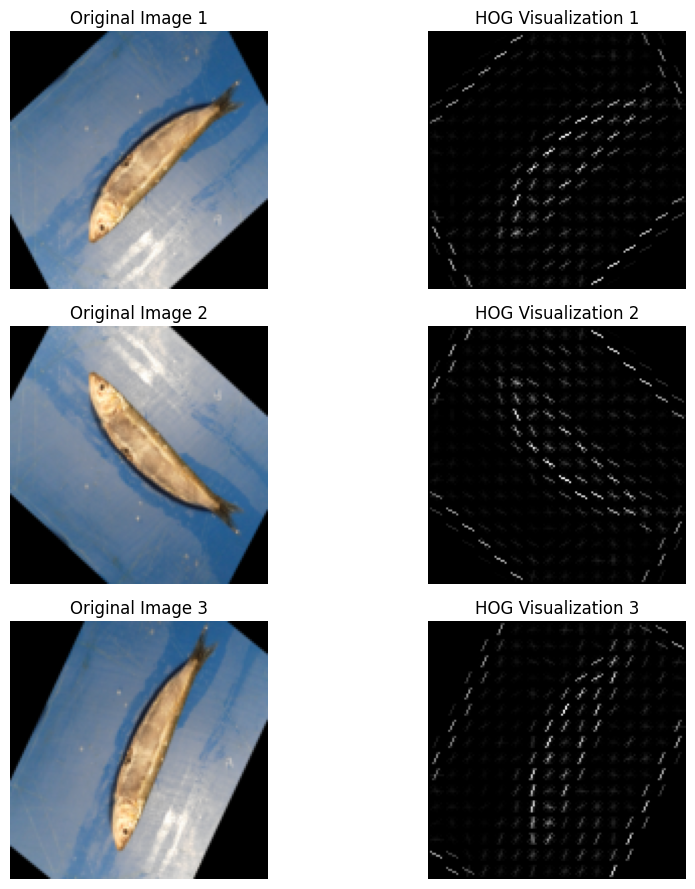

In [ ]:
def visualize_hog_samples_rgb(images, num=3):
    plt.figure(figsize=(10, num * 3))

    for i in range(num):
        img = images[i]

        # Compute HOG with visualization (supports RGB if you add channel_axis)
        if img.ndim == 3:
            features, hog_image = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True,
                channel_axis=-1       # <--- Important for RGB HOG
            )
        else:
            features, hog_image = hog(
                img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                visualize=True
            )

        # Enhance HOG image visibility
        hog_image = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))

        # Original
        plt.subplot(num, 2, i*2 + 1)
        plt.imshow(img if img.ndim == 3 else img, cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # HOG visualization
        plt.subplot(num, 2, i*2 + 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title(f"HOG Visualization {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    
visualize_hog_samples_rgb(X, num=3)

###  Compile and Train ANN model

In [6]:
# --- 5-Fold Cross-Validation Setup ---
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

num_classes = len(np.unique(y_full))
# Variables to hold data from the best performing fold
best_ann_score = -1
best_ann_model = None
best_ann_history = None
best_ann_y_pred = None   
best_ann_y_true = None   
best_ann_fold_index = -1

print("Starting 5-Fold CV for ANN...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_hog, y_full):
    # 1. Split Data
    X_t, X_v = X_full_hog[train_index], X_full_hog[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
    
    # 2. One-Hot Encoding for ANN
    y_t_oh = to_categorical(y_t, 9)
    y_v_oh = to_categorical(y_v, 9)
    
    # 3. Scale Data 
    scaler_cv = StandardScaler()
    X_t = scaler_cv.fit_transform(X_t)
    X_v = scaler_cv.transform(X_v)
    
    # 4. Define Model 
    model_cv = Sequential([
        Input(shape=(X_t.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # 5. Train
    print(f"Training Fold {fold_no}...", end=" ")
    history = model_cv.fit(X_t, y_t_oh, epochs=20, batch_size=64, validation_data=(X_v, y_v_oh), verbose=0)
    
    # 6. Evaluate
    loss, acc = model_cv.evaluate(X_v, y_v_oh, verbose=0)
    print(f"Accuracy: {acc*100:.2f}%")
    
    # 7. Save Best Fold Data
    if acc > best_ann_score:
        best_ann_score = acc
        best_ann_fold_index = fold_no
        best_ann_model = model_cv
        best_ann_history = history
        
        # Generate predictions for later evaluation cells
        preds_oh = model_cv.predict(X_v, verbose=0)
        best_ann_y_pred = np.argmax(preds_oh, axis=1)
        best_ann_y_true = y_v
        
    fold_no += 1

print(f"\nTraining Complete. Best ANN Fold: {best_ann_fold_index} (Accuracy: {best_ann_score*100:.2f}%)")

Starting 5-Fold CV for ANN...
Training Fold 1... Accuracy: 92.44%
Training Fold 2... Accuracy: 94.33%
Training Fold 3... Accuracy: 89.78%
Training Fold 4... Accuracy: 93.11%
Training Fold 5... Accuracy: 90.39%

Training Complete. Best ANN Fold: 2 (Accuracy: 94.33%)


In [7]:
best_ann_model.save(f"best_ann_model.h5")

###  ANN Model Evaluation

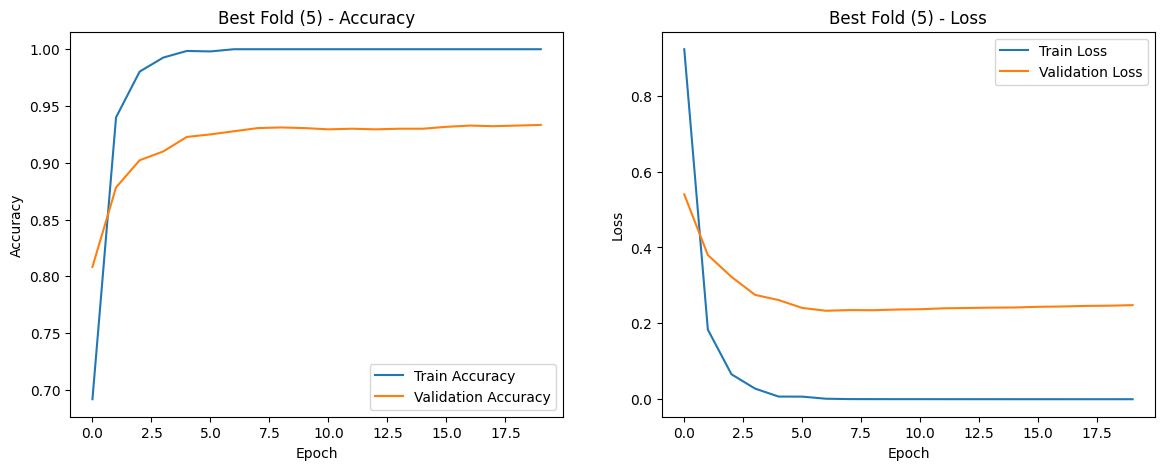

In [7]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(best_ann_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Best Fold ({best_ann_fold_index}) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(best_ann_history.history['loss'], label='Train Loss')
plt.plot(best_ann_history.history['val_loss'], label='Validation Loss')
plt.title(f'Best Fold ({best_ann_fold_index}) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Confusion Matrix (Best Fold: 5):
 [[175   0  12   0   1   0   0  12   0]
 [  0 185   4   2   2   4   0   2   1]
 [  3   1 192   1   0   1   0   1   1]
 [  4   2   1 188   1   1   1   1   1]
 [  1   1   0   0 197   0   0   0   1]
 [  1   1   1   2   2 186   2   2   3]
 [  4   0   3   3   1   0 189   0   0]
 [  8   0   8   0   1   2   1 179   1]
 [  0   3   0   0   6   1   0   1 189]]


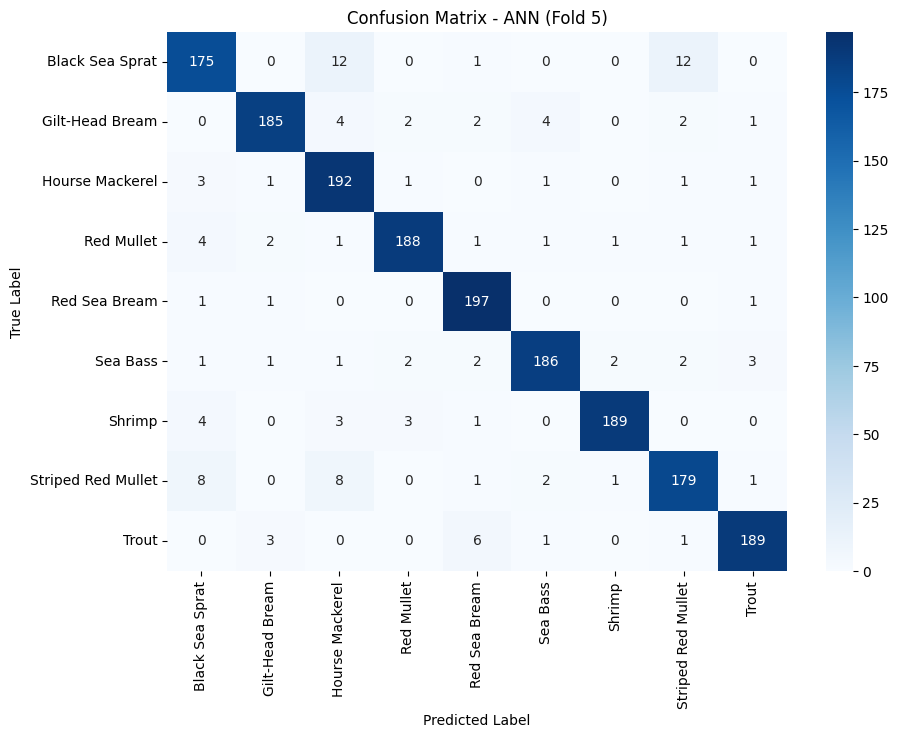

In [8]:
# Compute Matrix
conf_matrix_ann = confusion_matrix(best_ann_y_true, best_ann_y_pred)
print(f"Confusion Matrix (Best Fold: {best_ann_fold_index}):\n", conf_matrix_ann)

# Plot Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - ANN (Fold {best_ann_fold_index})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
print(f"Classification Report (Best Fold: {best_ann_fold_index}):\n")
print(classification_report(best_ann_y_true, best_ann_y_pred, target_names=class_names, digits=4))


Classification Report (Best Fold: 5):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.8929    0.8750    0.8838       200
   Gilt-Head Bream     0.9585    0.9250    0.9415       200
   Hourse Mackerel     0.8688    0.9600    0.9121       200
        Red Mullet     0.9592    0.9400    0.9495       200
     Red Sea Bream     0.9336    0.9850    0.9586       200
          Sea Bass     0.9538    0.9300    0.9418       200
            Shrimp     0.9793    0.9450    0.9618       200
Striped Red Mullet     0.9040    0.8950    0.8995       200
             Trout     0.9594    0.9450    0.9521       200

          accuracy                         0.9333      1800
         macro avg     0.9344    0.9333    0.9334      1800
      weighted avg     0.9344    0.9333    0.9334      1800



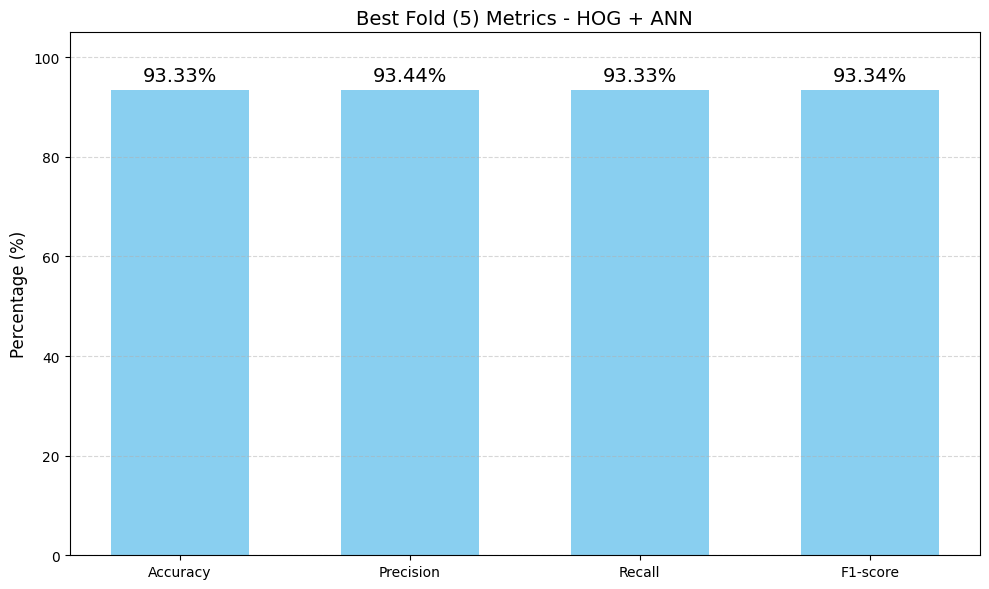

In [7]:
def plot_metrics_graph(metrics_values, title):
    # 1. Setup Data
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Check if input length matches expected metrics
    if len(metrics_values) != 4:
        print("Warning: Expected 4 metric values (Accuracy, Precision, Recall, F1).")

    # Convert values to percentages
    values_pct = [x * 100 for x in metrics_values]
    
    # 2. Create the Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars
    bars = ax.bar(metric_names, values_pct, color='#89CFF0', width=0.6, zorder=1)
    
    # 3. Add Value Labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, color='black')
    
    # 4. Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 105) 
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
    
    plt.tight_layout()
    plt.show()

HOG_ANN = [0.9333, 0.9344  ,  0.9333  ,  0.9334]
plot_metrics_graph(HOG_ANN, 'Best Fold (5) Metrics - HOG + ANN')

### KNN model

In [11]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Variables to hold best fold data
best_knn_score = -1
best_knn_y_pred = None
best_knn_y_true = None
best_knn_fold = -1

print("Starting 5-Fold CV for KNN...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_hog, y_full):
    # 1. Split Data
    X_t, X_v = X_full_hog[train_index], X_full_hog[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
    
    # 2. Scale Data (Fit on Train, Transform Val)
    scaler = StandardScaler()
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)
    
    # 3. Train
    knn_model.fit(X_t, y_t)
    
    # 4. Predict
    preds = knn_model.predict(X_v)
    acc = accuracy_score(y_v, preds)
    
    print(f"Fold {fold_no} Accuracy: {acc*100:.2f}%")
    
    # 5. Save Best
    if acc > best_knn_score:
        best_knn_score = acc
        best_knn_fold = fold_no
        best_knn_y_pred = preds
        best_knn_y_true = y_v
        
    fold_no += 1

print(f"\nBest KNN Fold: {best_knn_fold} (Accuracy: {best_knn_score*100:.2f}%)")



Starting 5-Fold CV for KNN...
Fold 1 Accuracy: 90.61%
Fold 2 Accuracy: 91.78%
Fold 3 Accuracy: 91.33%
Fold 4 Accuracy: 90.72%
Fold 5 Accuracy: 91.72%

Best KNN Fold: 2 (Accuracy: 91.78%)


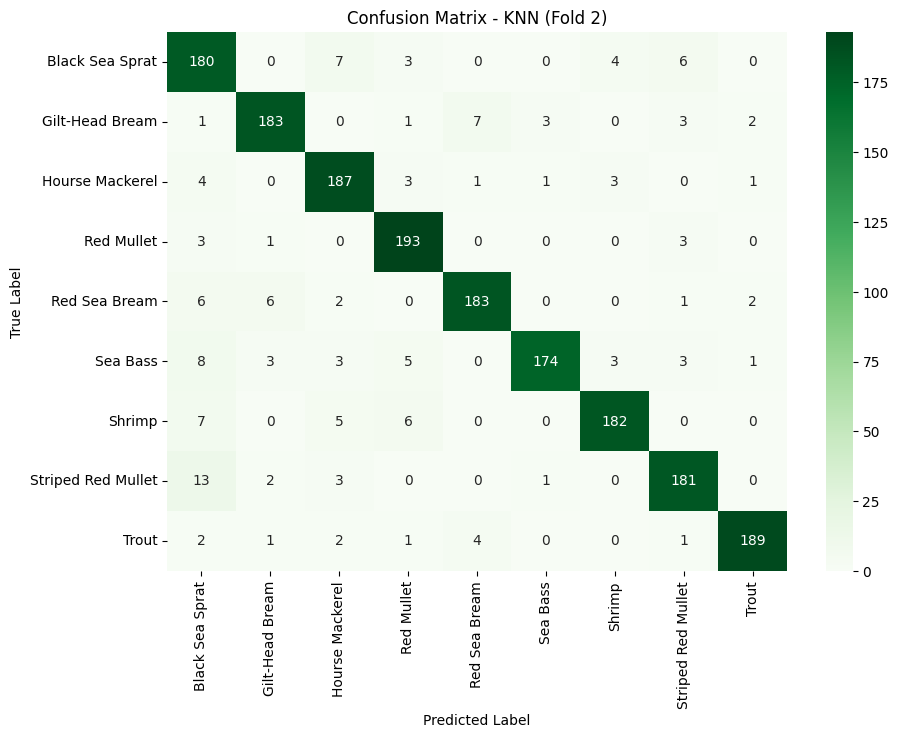

KNN Classification Report (Fold 2):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.8036    0.9000    0.8491       200
   Gilt-Head Bream     0.9337    0.9150    0.9242       200
   Hourse Mackerel     0.8947    0.9350    0.9144       200
        Red Mullet     0.9104    0.9650    0.9369       200
     Red Sea Bream     0.9385    0.9150    0.9266       200
          Sea Bass     0.9721    0.8700    0.9182       200
            Shrimp     0.9479    0.9100    0.9286       200
Striped Red Mullet     0.9141    0.9050    0.9095       200
             Trout     0.9692    0.9450    0.9570       200

          accuracy                         0.9178      1800
         macro avg     0.9205    0.9178    0.9183      1800
      weighted avg     0.9205    0.9178    0.9183      1800



In [13]:
# 1. Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(best_knn_y_true, best_knn_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - KNN (Fold {best_knn_fold})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print(f"KNN Classification Report (Fold {best_knn_fold}):\n")
print(classification_report(best_knn_y_true, best_knn_y_pred, target_names=class_names, digits=4))

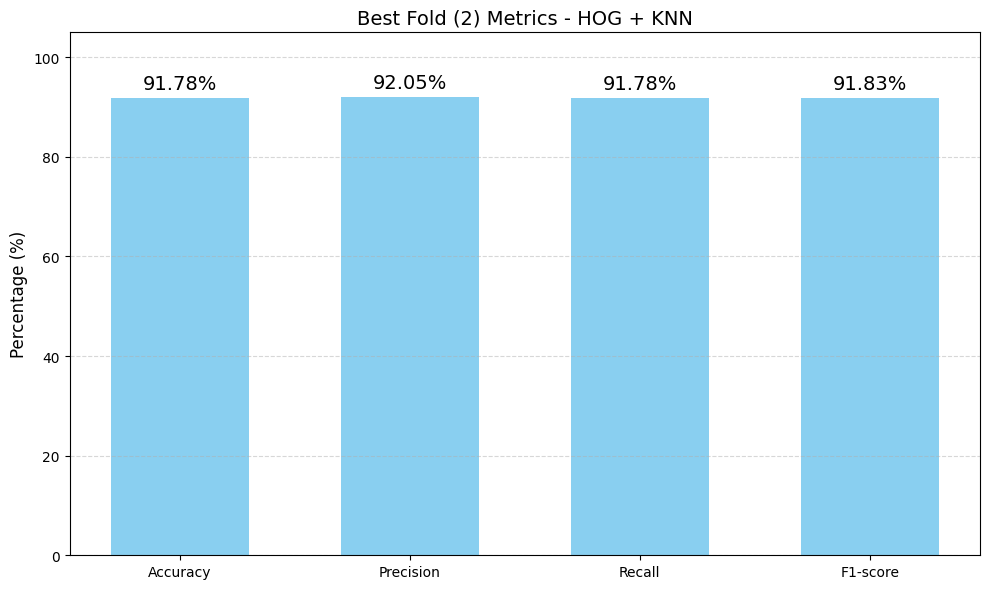

In [14]:
HOG_KNN = [0.9178, 0.9205  ,  0.9178  ,  0.9183]
plot_metrics_graph(HOG_KNN, 'Best Fold (2) Metrics - HOG + KNN')

### SVM model

In [6]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to hold best fold data
best_svm_score = -1
best_svm_y_pred = None
best_svm_y_true = None
best_svm_fold = -1
best_svm_model = None

print("Starting 5-Fold CV for SVM...")

fold_no = 1
for train_index, val_index in kfold.split(X_full_hog, y_full):
    # 1. Split Data
    X_t, X_v = X_full_hog[train_index], X_full_hog[val_index]
    y_t, y_v = y_full[train_index], y_full[val_index]
   
    # 2. Scale Data
    scaler = StandardScaler()
    X_t = scaler.fit_transform(X_t)
    X_v = scaler.transform(X_v)
    
    svm_model = SVC(kernel='rbf', probability=False)
   
    # 3. Train
    svm_model.fit(X_t, y_t)

    # 4. Predict
    preds = svm_model.predict(X_v)
    acc = accuracy_score(y_v, preds)
    print(f"Fold {fold_no} Accuracy: {acc*100:.2f}%")
    
    # 5. Save Best
    if acc > best_svm_score:
        best_svm_score = acc
        best_svm_fold = fold_no
        best_svm_y_pred = preds
        best_svm_y_true = y_v
        best_svm_model = svm_model
        
    fold_no += 1

print(f"\nBest SVM Fold: {best_svm_fold} (Accuracy: {best_svm_score*100:.2f}%)")


Starting 5-Fold CV for SVM...
Fold 1 Accuracy: 90.83%
Fold 2 Accuracy: 92.33%
Fold 3 Accuracy: 92.06%
Fold 4 Accuracy: 92.22%
Fold 5 Accuracy: 91.50%

Best SVM Fold: 2 (Accuracy: 92.33%)


In [7]:
import joblib

joblib.dump(best_svm_model, 'svm_model.pkl')

print("SVM model saved successfully as 'svm_model.pkl'")

SVM model saved successfully as 'svm_model.pkl'


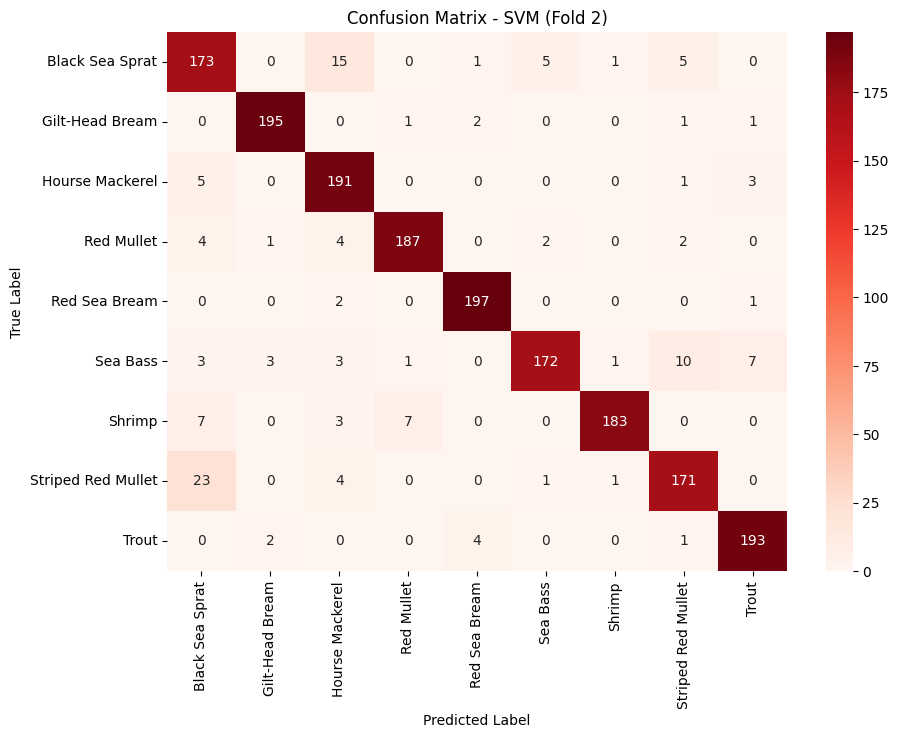

SVM Classification Report (Fold 2):

                    precision    recall  f1-score   support

   Black Sea Sprat     0.8047    0.8650    0.8337       200
   Gilt-Head Bream     0.9701    0.9750    0.9726       200
   Hourse Mackerel     0.8604    0.9550    0.9052       200
        Red Mullet     0.9541    0.9350    0.9444       200
     Red Sea Bream     0.9657    0.9850    0.9752       200
          Sea Bass     0.9556    0.8600    0.9053       200
            Shrimp     0.9839    0.9150    0.9482       200
Striped Red Mullet     0.8953    0.8550    0.8747       200
             Trout     0.9415    0.9650    0.9531       200

          accuracy                         0.9233      1800
         macro avg     0.9257    0.9233    0.9236      1800
      weighted avg     0.9257    0.9233    0.9236      1800



In [9]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

# 1. Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(best_svm_y_true, best_svm_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - SVM (Fold {best_svm_fold})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print(f"SVM Classification Report (Fold {best_svm_fold}):\n")
print(classification_report(best_svm_y_true, best_svm_y_pred, target_names=class_names, digits=4))  
  

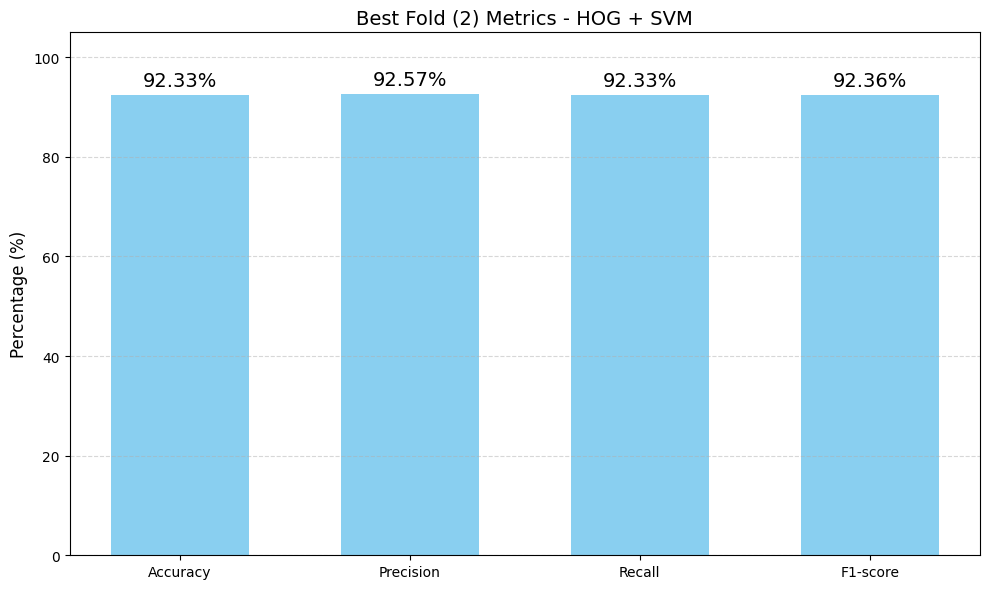

In [10]:
HOG_SVM = [0.9233, 0.9257 ,   0.9233   , 0.9236]
plot_metrics_graph(HOG_SVM, 'Best Fold (2) Metrics - HOG + SVM') 

### Saving the Models weight

In [12]:
import joblib

joblib.dump(best_ann_model, 'ann_hog_model.pkl')

['ann_hog_model.pkl']